In [1]:
import duckdb as ddb
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec

data = ddb.read_parquet("all_reviews/all_reviews.parquet")

In [ ]:
# columns and types
for x, item in enumerate(data.columns):
    print(str(item) + ":  " + str(data.dtypes[x]))

game:  VARCHAR
author_steamid:  BIGINT
author_num_games_owned:  INTEGER
author_num_reviews:  INTEGER
author_playtime_forever:  INTEGER
author_playtime_last_two_weeks:  INTEGER
author_playtime_at_review:  BIGINT
author_last_played:  INTEGER
language:  VARCHAR
review:  VARCHAR
timestamp_created:  INTEGER
timestamp_updated:  INTEGER
voted_up:  INTEGER
votes_up:  INTEGER
votes_funny:  INTEGER
weighted_vote_score:  FLOAT
comment_count:  INTEGER
steam_purchase:  INTEGER
received_for_free:  INTEGER
written_during_early_access:  INTEGER


In [ ]:
# print(data.describe())

['game', 'author_steamid', 'author_num_games_owned', 'author_num_reviews', 'author_playtime_forever', 'author_playtime_last_two_weeks', 'author_playtime_at_review', 'author_last_played', 'language', 'review', 'timestamp_created', 'timestamp_updated', 'voted_up', 'votes_up', 'votes_funny', 'weighted_vote_score', 'comment_count', 'steam_purchase', 'received_for_free', 'written_during_early_access']
┌─────────┬─────────────────────────────┬───────────────────────┬────────────────────────┬────────────────────┬─────────────────────────┬────────────────────────────────┬───────────────────────────┬────────────────────┬────────────┬───────────────────────────────────────────────┬────────────────────┬────────────────────┬───────────────────┬────────────────────┬────────────────────┬─────────────────────┬─────────────────────┬─────────────────────┬─────────────────────┬─────────────────────────────┐
│  aggr   │            game             │    author_steamid     │ author_num_games_owned │ author

In [ ]:
# IDEA:
# review scores from those who got the game for free vs those who had to pay for it
# is there an average of a higher rating for free / not purchased? for what games?

# plan: 
#   gather the top 3 games the most amount of reviews
#   find out the percentage of positive vs negative reviews
#   then find out the percentages from those who puchased vs did not purchase the game (include those who got the game for free)
#   analyze which games had which results, and do some further research on why this may be
#       this could be finding the reviews with the highest helpfulness or most upvotes
#       this could also include doing some outside reseach on reddit / internet

# find games with middle of the road reviews, grab the top 3 in review count
mid_reviewed_games = ddb.sql(f"""
    SELECT
        game,
        COUNT(*) AS review_count,
        AVG(CASE WHEN voted_up = 1 THEN 1.0 ELSE 0 END) * 100 AS average_positive_percentage
    FROM data
    GROUP BY game
    HAVING 
        average_positive_percentage BETWEEN 40 AND 60
        AND review_count > 100
    ORDER BY review_count DESC
    -- LIMIT 10
""").fetchdf()

print(mid_reviewed_games)

                                                   game  review_count  \
0                                         Call of Duty®        451506   
1                                     Battlefield™ 2042        227879   
2                                 鬼谷八荒 Tale of Immortal        219306   
3                                    EA SPORTS™ FIFA 23        141619   
4                            Warhammer 40,000: Darktide         77394   
5                                     雀魂麻将(MahjongSoul)         47821   
6                                              PAYDAY 3         42514   
7                                     theHunter Classic         40053   
8                                              NBA 2K22         38302   
9                                       Bless Unleashed         30108   
10                                          BLOCKADE 3D         26158   
11                       Call of Duty: Infinite Warfare         25907   
12                   Infestation: Survivor Stories 

In [69]:
# figure out purchased percentages
purchased_review_percentages = ddb.sql(f"""
    SELECT
        game,
        COUNT(*) AS review_count,
        SUM(CASE WHEN voted_up = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS positive_review_percentage
    FROM data
    WHERE 
        game IN (SELECT game FROM mid_reviewed_games)
        AND steam_purchase = 1
        AND received_for_free != 1
    GROUP BY game
    HAVING review_count > 100
    ORDER BY review_count DESC
""").fetchdf()

print(purchased_review_percentages)

# figure out not percentages
not_purchased_review_percentages = ddb.sql(f"""
    SELECT
        game,
        COUNT(*) AS review_count,
        SUM(CASE WHEN voted_up = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS positive_review_percentage
    FROM data
    WHERE 
        game IN (SELECT game FROM mid_reviewed_games)
        AND (steam_purchase = 0 OR received_for_free = 1)
    GROUP BY game
    HAVING review_count > 100
    ORDER BY review_count DESC
""").fetchdf()

print(purchased_review_percentages)
print(not_purchased_review_percentages)

                                                  game  review_count  \
0                                        Call of Duty®        244781   
1                                鬼谷八荒 Tale of Immortal        185173   
2                                    Battlefield™ 2042        169993   
3                                   EA SPORTS™ FIFA 23        113922   
4                           Warhammer 40,000: Darktide         65316   
5                                             PAYDAY 3         32143   
6                                             NBA 2K22         29107   
7                              Wo Long: Fallen Dynasty         17532   
8                   Infestation: Survivor Stories 2020         17236   
9                              Need for Speed™ Unbound         15935   
10                                            Devotion         15703   
11                                           Wayfinder         15373   
12                      Monster Hunter World: Iceborne         1

In [ ]:
# join table and find out the percentage difference for each game
joined_percentages = ddb.sql(f"""
    SELECT
        p.game,
        p.review_count,
        n.positive_review_percentage,
        p.positive_review_percentage,
        (n.positive_review_percentage - p.positive_review_percentage) AS percentage_difference
    FROM purchased_review_percentages p
    JOIN not_purchased_review_percentages n ON p.game = n.game
    ORDER BY p.review_count DESC;
""").fetchdf()

print(joined_percentages)

                                                  game  review_count  \
0                                        Call of Duty®        244781   
1                                鬼谷八荒 Tale of Immortal        185173   
2                                    Battlefield™ 2042        169993   
3                                   EA SPORTS™ FIFA 23        113922   
4                           Warhammer 40,000: Darktide         65316   
5                                             PAYDAY 3         32143   
6                                             NBA 2K22         29107   
7                              Wo Long: Fallen Dynasty         17532   
8                   Infestation: Survivor Stories 2020         17236   
9                              Need for Speed™ Unbound         15935   
10                                            Devotion         15703   
11                                           Wayfinder         15373   
12                      Monster Hunter World: Iceborne         1

In [90]:
# calculate average (top 30 by reviews)
average_percentage_top_30 = ddb.sql(f"""
    SELECT AVG(percentage_difference) AS average_percentage_difference_top_30
    FROM (
        SELECT percentage_difference
        FROM joined_percentages
        ORDER BY review_count DESC
        LIMIT 30
    ) AS top_30_games
""").fetchdf()

# calculate average (>50000 reviews)
average_percentage_50000 = ddb.sql(f"""
    SELECT AVG(percentage_difference) AS average_percentage_difference_50000
    FROM joined_percentages
    WHERE review_count > 50000;
""").fetchdf()

# calculate average (>10000 reviews)
average_percentage_10000 = ddb.sql(f"""
    SELECT AVG(percentage_difference) AS average_percentage_difference_10000
    FROM joined_percentages
    WHERE review_count > 10000;
""").fetchdf()

# calculate average (>1000 reviews)
average_percentage_1000 = ddb.sql(f"""
    SELECT AVG(percentage_difference) AS average_percentage_difference_1000
    FROM joined_percentages
    WHERE review_count > 1000;
""").fetchdf()

# calculate average
average_percentage = ddb.sql(f"""
    SELECT AVG(percentage_difference) AS average_percentage_difference
    FROM joined_percentages
""").fetchdf()

# calculate average APR purchased
average_percentage_purchased = ddb.sql(f"""
    SELECT AVG(positive_review_percentage_1) AS APR_purchased
    FROM joined_percentages
""").fetchdf()

# calculate average APR not purchased
average_percentage_not_purchased = ddb.sql(f"""
    SELECT AVG(positive_review_percentage) AS APR_not_purchased
    FROM joined_percentages
""").fetchdf()

# calculate max
max_percentage = ddb.sql(f"""
    SELECT game, review_count, percentage_difference
    FROM joined_percentages
    -- WHERE review_count > 1000
    ORDER BY percentage_difference DESC
    LIMIT 3;
""").fetchdf()

# calculate min
min_percentage = ddb.sql(f"""
    SELECT game, review_count, percentage_difference
    FROM joined_percentages
    -- WHERE review_count > 1000
    ORDER BY percentage_difference ASC
    LIMIT 3;
""").fetchdf()

# top 10 differences from top reviews
top_10_percentage = ddb.sql(f"""
    SELECT game, review_count, percentage_difference
    FROM joined_percentages
    ORDER BY review_count DESC
    LIMIT 10;
""").fetchdf()

print(average_percentage_top_30)
print()
print(average_percentage_50000)
print()
print(average_percentage_10000)
print()
print(average_percentage_1000)
print()
print(average_percentage)
print()
print(average_percentage_purchased)
print()
print(average_percentage_not_purchased)
print()
print(max_percentage)
print()
print(min_percentage)
print()
print(top_10_percentage)

   average_percentage_difference_top_30
0                             -3.175662

   average_percentage_difference_50000
0                            -2.390343

   average_percentage_difference_10000
0                            -2.925769

   average_percentage_difference_1000
0                           -2.574916

   average_percentage_difference
0                      -2.900997

   APR_purchased
0      53.816771

   APR_not_purchased
0          50.915774

                                        game  review_count  \
0  Sid Meier’s Civilization® VI: Leader Pass           392   
1      Airport Firefighters - The Simulation           107   
2     Company of Heroes 2 - Ardennes Assault           266   

   percentage_difference  
0              30.959453  
1              23.720893  
2              23.427967  

                    game  review_count  percentage_difference
0          The Anacrusis           457             -42.429116
1                Grapple           227             -38.77

/tmp/ipykernel_22483/4142275130.py:49: UserWarning: Glyph 39740 (\N{CJK UNIFIED IDEOGRAPH-9B3C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_22483/4142275130.py:49: UserWarning: Glyph 35895 (\N{CJK UNIFIED IDEOGRAPH-8C37}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_22483/4142275130.py:49: UserWarning: Glyph 20843 (\N{CJK UNIFIED IDEOGRAPH-516B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_22483/4142275130.py:49: UserWarning: Glyph 33618 (\N{CJK UNIFIED IDEOGRAPH-8352}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_22483/4142275130.py:49: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_22483/4142275130.py:49: UserWarning: Glyph 23500 (\N{CJK UNIFIED IDEOGRAPH-5BCC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_22483/4142275130.py:49: UserWarning: Glyph 32705 (\N{CJK UNIFIED IDEOGRAP

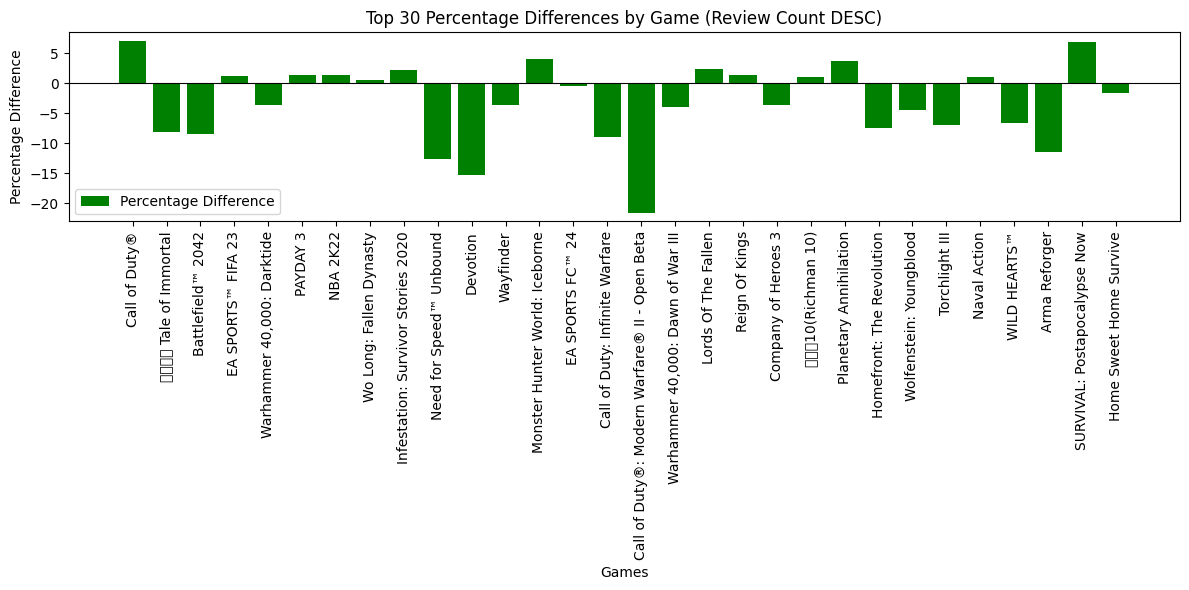

In [79]:
# Sort by review count and take the top 30
top_games = joined_percentages.sort_values(by='review_count', ascending=False).head(30)

# Set the figure size
plt.figure(figsize=(12, 6))

# Set the positions of the bars on the x-axis
index = range(len(top_games))

# Plotting the percentage differences
plt.bar(index, top_games['percentage_difference'], color='green', label='Percentage Difference')

# Adding a horizontal line at y=0
plt.axhline(0, color='black', linewidth=0.8, linestyle='-')

# Adding labels and title
plt.xlabel('Games')
plt.ylabel('Percentage Difference')
plt.title('Top 30 Percentage Differences by Game (Review Count DESC)')
plt.xticks(index, top_games['game'], rotation=90)  # Set x-axis labels vertical

plt.yticks(range(-20, 10, 5))  # Adjust the range as necessary

# Show the plot
plt.tight_layout()
plt.legend()
plt.show()

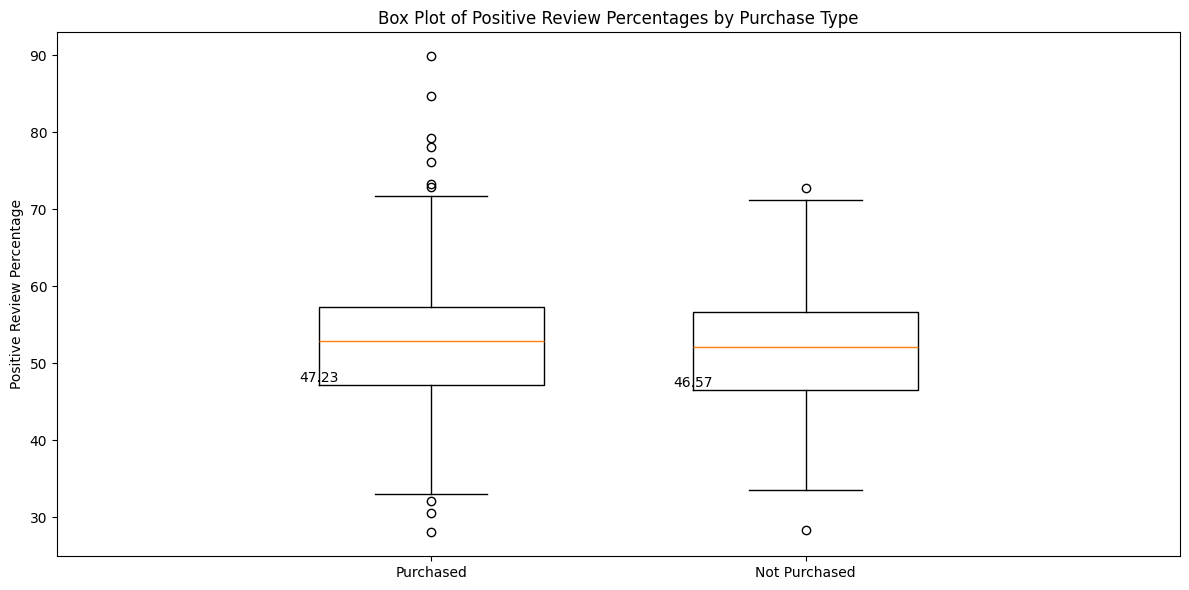

In [87]:
# BOX PLOT IS NOT VERY GOOD FOR VISUALIZATION IN THIS CASE ****************************************************

# # Add a column to indicate the type of purchase
# purchased_review_percentages['Type'] = 'Purchased'
# not_purchased_review_percentages['Type'] = 'Not Purchased'

# # Concatenate the two DataFrames
# combined_df = pd.concat([purchased_review_percentages, not_purchased_review_percentages])

# # Set the figure size
# plt.figure(figsize=(12, 6))

# # Create the box plot with a closer spacing
# box_positions = [1, 1.5]  # Adjust positions to be closer together
# box_plot = plt.boxplot([combined_df[combined_df['Type'] == 'Purchased']['positive_review_percentage'],
#                         combined_df[combined_df['Type'] == 'Not Purchased']['positive_review_percentage']],
#                        positions=box_positions,
#                        widths=0.3)  # Set width for the boxes

# # Adding labels and title
# plt.ylabel('Positive Review Percentage')
# plt.title('Box Plot of Positive Review Percentages by Purchase Type')

# # Adding labels to the boxes (excluding outliers)
# for box in box_plot['boxes']:
#     # Get the median value for the box
#     median_value = box.get_ydata()[1]  # Median is the second point in the box
#     plt.text(box.get_xdata()[0], median_value, f'{median_value:.2f}', 
#              horizontalalignment='center', verticalalignment='bottom')

# # Set x-ticks
# plt.xticks(box_positions, ['Purchased', 'Not Purchased'])

# # Show the plot
# plt.tight_layout()
# plt.show()